In [307]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from random import sample, shuffle
from math import floor
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [336]:
class Dense(tf.Module):  # Denesly connected leyer
    # Note: No need for `in_features`
    def _linear_act(x):
        return x
    
    def __init__(self, out_features, act_func = _linear_act, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features  # Number of outputs
        self.act_func = act_func  # Activation function

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(
                tf.random.normal([x.shape[-1], self.out_features]), name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return self.act_func(y)


class Model(tf.Module):
    def __init__(self, layers=[], name=None):
        super().__init__(name=name)
        self.layers = layers

    # Feed forward on call
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def _loss(model, inputs, target_y):
    pred_y = model(inputs)
    return tf.reduce_mean(tf.square(target_y - pred_y))


def _grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = _loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def _get_batches(X, Y, batch_size):
    n_data = len(X)
    # Shuffle data
    c = list(zip(X, Y))
    shuffle(c)
    X, Y = zip(*c)
    # Splitting into batches
    X, Y = np.array(X).astype('float32'), np.array(Y).astype('float32')
    x, y = [], []
    for i in range(0, n_data - batch_size, batch_size):
        x.append(X[i:i+batch_size])
        y.append(Y[i:i+batch_size])
    return x, y


def train(model, X, Y, epochs=10, batch_size=1,
          optimiser=tf.optimizers.Adam(0.01)):

    train_loss_results = []
    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        # Creating new batches for every epoch
        x, y = _get_batches(X, Y, batch_size)
        for i in range(0, len(x)):  # For all each batch
            loss_value, grads = _grad(model, x[i], y[i])
            optimiser.apply_gradients(zip(grads, model.trainable_variables))
            
            epoch_loss_avg.update_state(loss_value)

        train_loss_results.append(epoch_loss_avg.result().numpy())
        if((epoch+1) % 10 == 0):
            print("Epoch: {}; Loss: {}".format(
                epoch+1, epoch_loss_avg.result().numpy()))
    return train_loss_results

In [337]:
arecibo_df = pd.read_csv('Arecibo_DF') 
nancay_df = pd.read_csv('Nancay_DF')

x_values = arecibo_df.drop(['M HI ', 'Name '], axis=1).values.astype('float32')
x_values = scale(x_values)
y_values = arecibo_df['M HI '].values.astype('float32')
y_values = np.reshape(y_values, (-1, 1))

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Epoch: 10; Loss: 0.23583155870437622
Epoch: 20; Loss: 0.1673198640346527
Epoch: 30; Loss: 0.14398008584976196
Epoch: 40; Loss: 0.13227398693561554
Epoch: 50; Loss: 0.11731507629156113
Epoch: 60; Loss: 0.10178839415311813
Epoch: 70; Loss: 0.09482945501804352
Epoch: 80; Loss: 0.09448430687189102
Epoch: 90; Loss: 0.08895770460367203
Epoch: 100; Loss: 0.08592737466096878
Epoch: 110; Loss: 0.0763658657670021
Epoch: 120; Loss: 0.0656074583530426
Epoch: 130; Loss: 0.06831777095794678
Epoch: 140; Loss: 0.0651920884847641
Epoch: 150; Loss: 0.05976163223385811
Epoch: 160; Loss: 0.05687347799539566
Epoch: 170; Loss: 0.05376110225915909
Epoch: 180; Loss: 0.04962971433997154
Epoch: 190; Loss: 0.053662966936826706
Epoch: 200; Loss: 0.049139998853206635
Epoch: 210; Loss: 0.04457392916083336
Epoch: 220; Loss: 0.043893907219171524
Epoch: 230; Loss: 0.039848439395427704
Epoch: 240; Loss: 0.044109806418418884
Epoch: 250; Loss: 0.04094565287232399
Epoch: 260; Loss: 0.04189037159085274
Epoch: 270; Loss: 0.

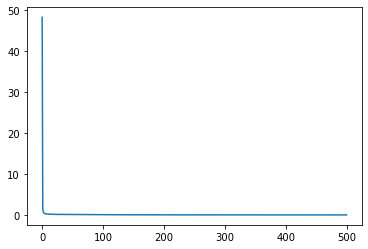

In [368]:
model = Model([Dense(16, act_func=tf.nn.softmax),
               Dense(32, tf.nn.sigmoid),
               Dense(16, tf.nn.elu),
              Dense(1)])
results = train(model, x_values, y_values, epochs=500,
                batch_size=8, optimiser=tf.optimizers.SGD(0.01))
plt.plot(results)

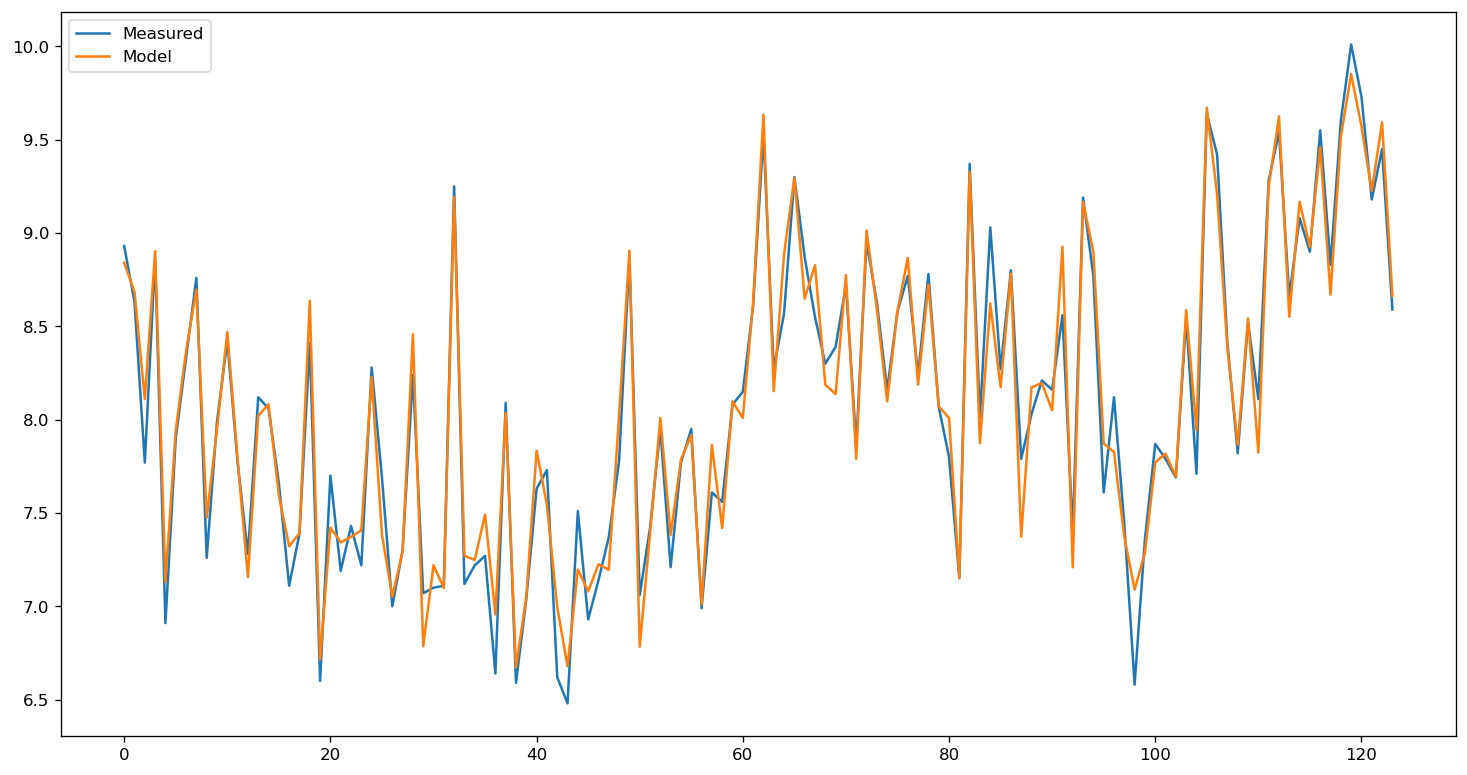

In [369]:
y_pred = model(x_values)
y = y_values
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(y)), y)
model_l, = plt.plot(range(0, len(y)), y_pred)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [370]:
nancay_x = nancay_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
nancay_x = scale(nancay_x)

nancay_y = nancay_df['MHI'].values

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


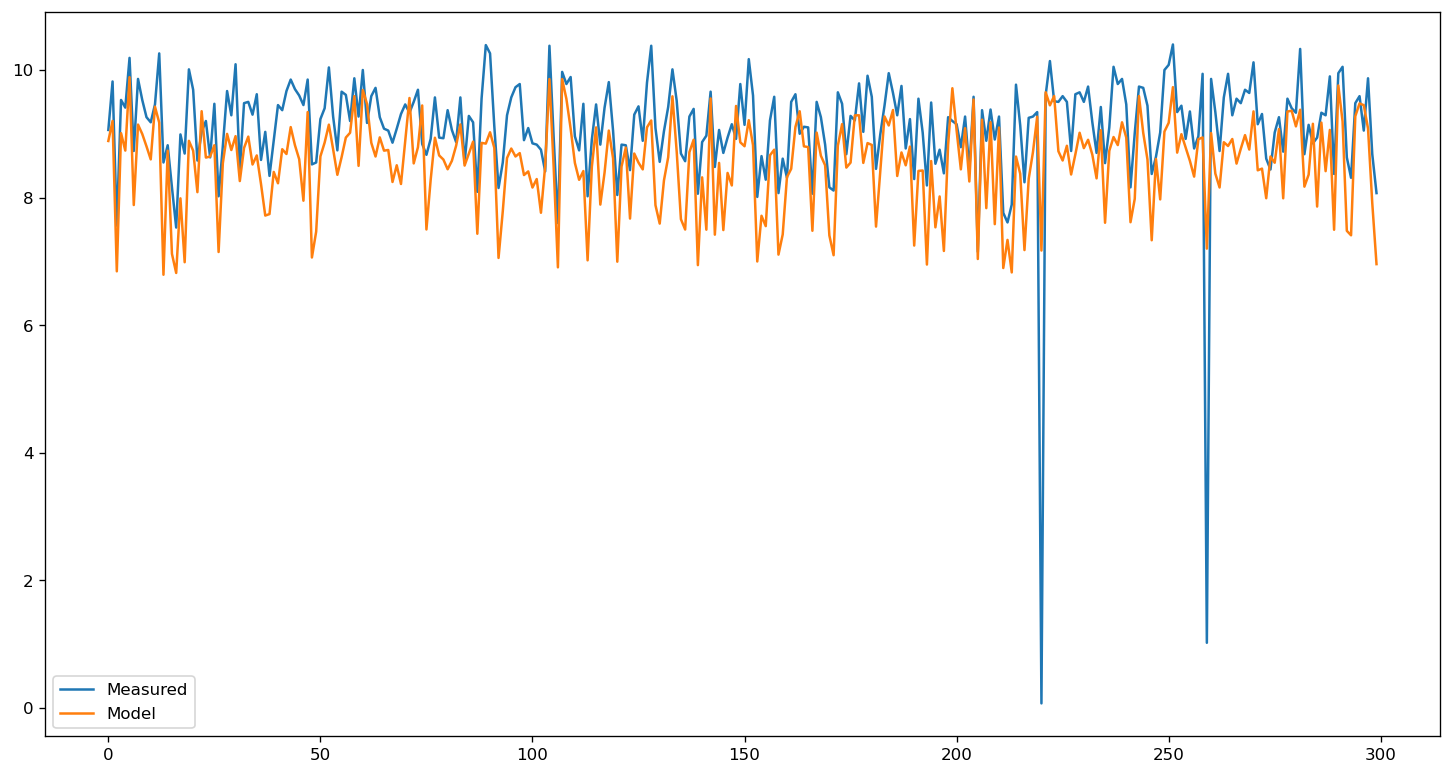

In [371]:
ran = 300
nancay_x_sub = nancay_x[0:ran]
nancay_y_sub = nancay_y[0:ran]
nancay_pred_y = model(nancay_x_sub)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, ran), nancay_y_sub)
model_l, = plt.plot(range(0, ran), nancay_pred_y)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()